In [2]:
import sys, os
import numpy as np
import collections
import mpmath

mpmath.mp.dps = 500
def pval(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath, chrom):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pval( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp))
#             res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=, TFdist=None, TFname=None))
    return res


datadir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm"
chrms = np.arange(1,23)
tissues = ["gtex-ms"]
expressions = ["lasso"] 
sbs = ["0.05"]
methods = ["tejaas", "tejaas_rand"]
snp_res_dict = collections.defaultdict(dict)

for sb in sbs:
    for expr in expressions:
        snp_res_dict[sb][expr] = collections.defaultdict(dict)
        for tissue in tissues:
            snp_res_dict[sb][expr][tissue] = collections.defaultdict(dict)
            for method in methods:
                snp_res = list()
                print(tissue, method, expr, end=" ")
                for chrom in chrms:
                    print(chrom, end=" ")
                    inputfile = os.path.join(datadir,expr,tissue,method,"permnull_sb"+sb,"chr"+str(chrom),"rr.txt.ld.new")
                    snp_res += tejaas(inputfile, chrom)
                print("")
                snp_res_dict[sb][expr][tissue][method] = snp_res

gtex-ms tejaas lasso 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
gtex-ms tejaas_rand lasso 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 


In [3]:
from operator import attrgetter

mysb="0.05"
myexpr="lasso"
mytissue="gtex-ms"
mymethod="tejaas"
snplist = snp_res_dict[mysb][myexpr][mytissue][mymethod]
sorted_list = sorted(snplist, key=attrgetter('logp'), reverse=True)

mymethod="tejaas_rand"
snplist_random = snp_res_dict[mysb][myexpr][mytissue][mymethod]
sorted_list_random = sorted(snplist_random, key=attrgetter('logp'), reverse=True)

In [7]:
# Benjamini Hochberg

alpha = 0.05
M = len(sorted_list)
print("Total SNPs: {:d}".format(M))
thresholds = -np.log10( np.arange(1, M+1) *  (alpha / M ) )

Total SNPs: 525787


In [16]:
limit=0
counter=0
k = 0
for i, e in enumerate(zip(sorted_list, thresholds)):
    snp, t = e
    print(e[0].rsid, end= ", ")
    if snp.logp < t:
        print(i, e)
        k = i
        counter += 1
        if counter >= limit:
            break
        

rs149320310, rs142125886, rs6826551, rs186244366, rs7117007, rs4781088, rs76730163, rs193195607, rs185123150, rs3102567, rs186187911, rs79335590, rs28412121, rs186157005, rs113443759, rs71382284, rs6930957, rs36159928, rs143314019, rs188831770, rs4581711, rs62219297, rs10134993, rs2116711, rs3989636, rs13008864, rs8141164, rs211756, rs193078978, rs10910140, 29 (SNPRes(rsid='rs10910140', chrom=1, pos=233510079, logp=5.355315281604121), 5.5447185849853735)


In [9]:
limit=0
counter=0
k = 0
for i, e in enumerate(zip(sorted_list_random, thresholds)):
    snp, t = e
    if snp.logp < t:
        print(i, e)
        k = i
        counter += 1
        if counter >= limit:
            break

91 (SNPRes(rsid='rs11074974', chrom=16, pos=11487344, logp=5.046846521241486), 5.0580520123594805)


In [10]:
import matplotlib.pyplot as plt

pvals = np.power(10, [-x.logp for x in sorted_list])
pvals_random = np.power(10, [-x.logp for x in sorted_list_random])

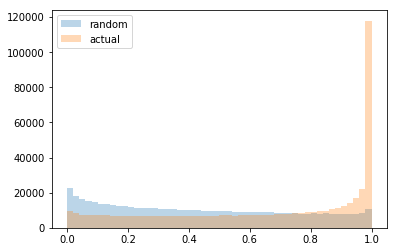

In [11]:
plt.hist(pvals_random, bins=50, label="random", alpha = 0.3)
plt.hist(pvals, bins=50, label="actual", alpha = 0.3)
plt.legend()
plt.show()